## 데이터셋 준비 (CIFAR-10)

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import urllib3
urllib3.disable_warnings()

tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete0QE2G4/cifar10-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete0QE2G4/cifar10-test.tfrecord
Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [ ]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


## Input Normalization

Data Normalization 은 데이터의 범위를 사용자가 원하는 범위로 제한하는 것이다. 이를 통해 머신러닝에서는 scale이 큰 feature의 영향이 비대해지는 것을 방지하고, 딥러닝에서 Local optimum에 빠질 위험을 줄여 학습 속도를 향상시킬 수 있다. 

다음 그림을 살펴보면 정규화 한 경우의 Cost function이 Local optimum에서 더 빨리 빠져나오는 것을 확인할 수 있다. 

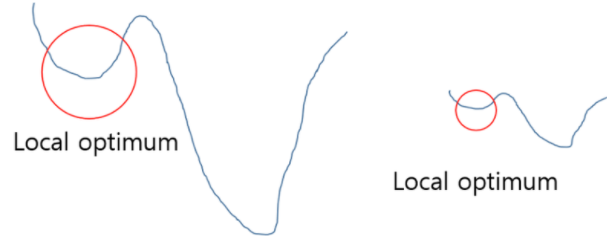

이미지 데이터의 경우 픽셀 정보를 0 ~ 255 사이의 값으로 가지는데, 이를 255로 나누어주면 0 ~ 1 사이의 값을 가지게 된다. 이미지는 픽셀 수를 이용해 크기를 나타내며, 한 픽셀이 가진 채널 값은 픽셀의 색을 표현한다. RGB는 Red, Green, Blue 세 가지 색을 이용해 표현하는 방식이고, 그레이스케일은 흑과 백만을 표현하는 하나의 채널을 가진 이미지이다. RGB나 그레이 스케일 외에도 HSV, CMYK 등 인쇄 또는 이미지 작업을 위해 사용되는 다양한 채널 체계가 있다.





In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# CIFAR-10 클래스 수 확인
ds_info.features["label"].num_classes

10

In [ ]:
# CIFAR-10 클래스 확인
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

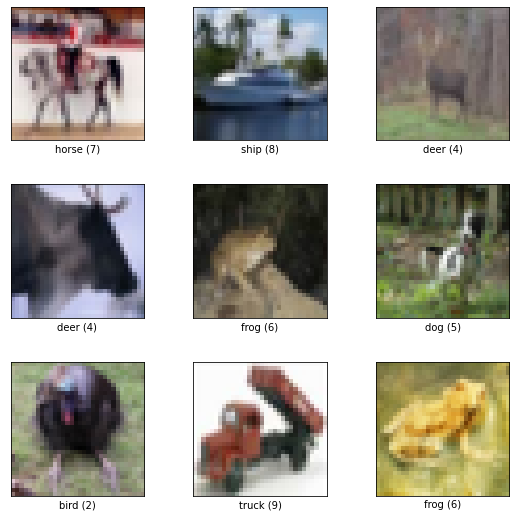

In [ ]:
# train 이미지 샘플 확인
fig = tfds.show_examples(ds_train, ds_info)

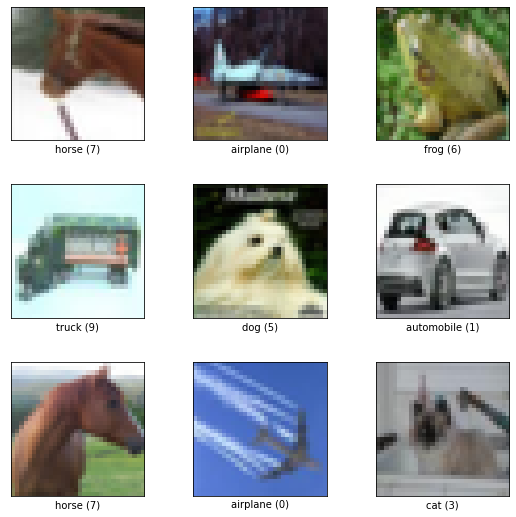

In [ ]:
# test 이미지 샘플 확인
fig = tfds.show_examples(ds_test, ds_info)

## VGG 기본 블록 만들기

모델을 프로그램으로 구현하는 과정에서는 논문의 모델을 그대로 구현하는 것도 중요하지만, 구현 시에 반복되는 부분을 줄여서 하이퍼파라미터 또는 변수를 변경하거나 모델 구조가 변경될 때 손쉽게 바꿀 수 있도록 만들어 놓는 것이 필요하다.

<br>

최근 나오는 일반적인 딥러닝 모델에서 이렇게 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위를 블록(block) 이라고 부른다. 레이어(layer) 는 기본적으로 텐서플로우(TensorFlow), 케라스(Keras), 파이토치(PyTorch) 등에서 기본적으로 제공하는 단위이다. 여기서 한 단계 위인 "블록"을 단위로 모델을 만들 수 있어야 한다.


---
ResNet을 바로 구현하는 것은 어려울 수 있으므로, 지금부터 조금 더 간단한 블록이 반복되는 VGG를 예시로 구현해 보겠습니다.



In [ ]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [ ]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [ ]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________

## VGG-16

In [ ]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [ ]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

## VGG-19

In [ ]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

## VGG-16 vs VGG-19

In [ ]:
BATCH_SIZE = 256
EPOCH = 15

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [ ]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 34s 86ms/step - loss: 2.1819 - accuracy: 0.1929 - val_loss: 2.0460 - val_accuracy: 0.2774
Epoch 2/15
195/195 [==============================] - 15s 77ms/step - loss: 1.9970 - accuracy: 0.2816 - val_loss: 1.9337 - val_accuracy: 0.3036
Epoch 3/15
195/195 [==============================] - 15s 77ms/step - loss: 1.8642 - accuracy: 0.3344 - val_loss: 1.8258 - val_accuracy: 0.3501
Epoch 4/15
195/195 [==============================] - 15s 77ms/step - loss: 1.7471 - accuracy: 0.3779 - val_loss: 1.7211 - val_accuracy: 0.3834
Epoch 5/15
195/195 [==============================] - 15s 77ms/step - loss: 1.6616 - accuracy: 0.4026 - val_loss: 1.6474 - val_accuracy: 0.4299
Epoch 6/15
195/195 [==============================] - 15s 77ms/step - loss: 1.6039 - accuracy: 0.4229 - val_loss: 1.6130 - val_accuracy: 0.4129
Epoch 7/15
195/195 [==============================] - 15s 77ms/step - loss: 1.5452 - accuracy: 0.4452 - val_loss: 1.5302 - val_accuracy: 0.4391
Epo

In [ ]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 22s 90ms/step - loss: 2.2348 - accuracy: 0.1592 - val_loss: 2.1104 - val_accuracy: 0.2436
Epoch 2/15
195/195 [==============================] - 17s 89ms/step - loss: 2.0314 - accuracy: 0.2560 - val_loss: 1.9475 - val_accuracy: 0.2781
Epoch 3/15
195/195 [==============================] - 17s 89ms/step - loss: 1.8790 - accuracy: 0.3149 - val_loss: 1.8374 - val_accuracy: 0.3386
Epoch 4/15
195/195 [==============================] - 17s 89ms/step - loss: 1.7596 - accuracy: 0.3590 - val_loss: 1.7454 - val_accuracy: 0.3678
Epoch 5/15
195/195 [==============================] - 17s 89ms/step - loss: 1.6698 - accuracy: 0.3929 - val_loss: 1.6631 - val_accuracy: 0.3939
Epoch 6/15
195/195 [==============================] - 17s 89ms/step - loss: 1.6078 - accuracy: 0.4174 - val_loss: 1.6209 - val_accuracy: 0.4127
Epoch 7/15
195/195 [==============================] - 17s 89ms/step - loss: 1.5658 - accuracy: 0.4332 - val_loss: 1.5556 - val_accuracy: 0.4465
Epo

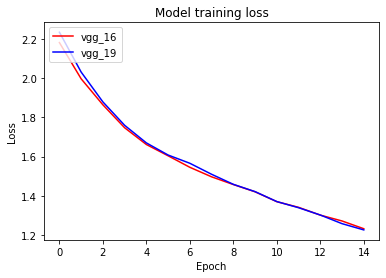

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

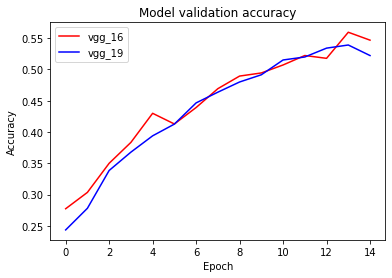

In [ ]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()